In [15]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('form5500_data/config.json') as f:
    conf = json.load(f)
    host = conf['host']
    database = conf['database']
    user = conf['user']
    passw = conf['passw']
conn_str = "host={} dbname={} user={} password={}".format(host, database, user, passw)
conn = psycopg2.connect(conn_str)

In [3]:
query = '''SELECT sb.SB_EIN, sb.SB_PN, sb.SB_EFF_INT_RATE_PRCNT, sb.SB_PLAN_TYPE_CODE,
       sb.SB_TOT_PARTCP_CNT, sb.SB_ACT_PARTCP_CNT, SB_TERM_PARTCP_CNT, SB_RTD_PARTCP_CNT,
       sb.SB_TOT_FNDNG_TGT_AMT, SB_LIAB_ACT_TOT_FNDNG_TGT_AMT, SB_TERM_FNDNG_TGT_AMT, SB_RTD_FNDNG_TGT_AMT,
       sb.SB_PLAN_YEAR_BEGIN_DATE, f.TYPE_PENSION_BNFT_CODE,
       f.PLAN_NAME, f.SPONSOR_DFE_NAME
       FROM sb_full sb 
       LEFT JOIN f5500_full f 
       ON sb.SB_EIN = f.SPONS_DFE_EIN AND sb.SB_PN = f.SPONS_DFE_PN 
       WHERE sb.SB_PLAN_TYPE_CODE = '1'; '''

"\n       WHERE sb.SB_PLAN_YEAR_BEGIN_DATE BETWEEN '2017-01-01' AND '2017-12-31'\n       AND sb.SB_PLAN_TYPE_CODE = '1';"

In [4]:
df = pd.read_sql(query, con=conn)
conn.close()

In [5]:
df

,sb_ein,sb_pn,sb_eff_int_rate_prcnt,sb_plan_type_code,sb_tot_partcp_cnt,sb_act_partcp_cnt,sb_term_partcp_cnt,sb_rtd_partcp_cnt,sb_tot_fndng_tgt_amt,sb_liab_act_tot_fndng_tgt_amt,sb_term_fndng_tgt_amt,sb_rtd_fndng_tgt_amt,sb_plan_year_begin_date,type_pension_bnft_code,plan_name,sponsor_dfe_name
0,841292364,2,6.07,1,5,5,None,None,0.0,NaN,NaN,NaN,2015-01-01,1A1C1F3D,"MAECKER TEAM, INC. CASH BALANCE PLAN","MAECKER TEAM, INC."
1,841292364,2,5.87,1,5,5,None,None,104192.0,104192.0,NaN,NaN,2016-01-01,1A1C1F3D,"MAECKER TEAM, INC. CASH BALANCE PLAN","MAECKER TEAM, INC."
2,841292364,2,4.23,1,5,4,1,None,228996.0,227368.0,1628.0,NaN,2017-01-01,1A1C1F3D,"MAECKER TEAM, INC. CASH BALANCE PLAN","MAECKER TEAM, INC."
3,274367692,2,6.44,1,12,12,0,0,0.0,0.0,0.0,0.0,2017-01-01,1A1C3D,"RWN CONTRACTORS, LLC CASH BALANCE PLAN","RWN CONTRACTORS, LLC"
4,204215382,2,5.48,1,4,4,0,0,0.0,0.0,0.0,0.0,2014-01-01,1A1I3D,"M-KOV, INC. DEFINED BENEFIT PLAN","M-KOV, INC."
5,204215382,2,5.43,1,4,4,0,0,350345.0,350345.0,0.0,0.0,2015-01-01,1A1I3D,"M-KOV, INC. DEFINED BENEFIT PLAN","M-KOV, INC."
6,204215382,2,5.32,1,4,3,1,0,518517.0,515488.0,3029.0,0.0,2016-01-01,1A1I3D,"M-KOV, INC. DEFINED BENEFIT PLAN","M-KOV, INC."
7,10193391,1,7.00,1,115,37,16,62,12813488.0,3174530.0,533495.0,9105463.0,2012-01-01,1A,EMPLOYEES ANNUITY PLAN PORTLAND PIPE LINE CORP...,PORTLAND PIPE LINE CORPORATION
8,10193391,1,6.31,1,115,36,15,64,14413525.0,3729653.0,552877.0,10130995.0,2013-01-01,1A,EMPLOYEES ANNUITY PLAN PORTLAND PIPE LINE CORP...,PORTLAND PIPE LINE CORPORATION
9,10193391,1,6.47,1,114,34,15,65,15022714.0,4674443.0,547887.0,9800384.0,2014-01-01,1A,EMPLOYEES ANNUITY PLAN PORTLAND PIPE LINE CORP...,PORTLAND PIPE LINE CORPORATION


In [ ]:
df.info()

<h1>Data Clean Up and Parsing</h1>

<h3>Convert object counts to numeric</h3>

In [6]:
clean_list = ['sb_tot_partcp_cnt', 'sb_act_partcp_cnt','sb_term_partcp_cnt', 'sb_rtd_partcp_cnt']

for c in clean_list:
    df[c] = pd.to_numeric(df[c])

df['sb_eff_int_rate_prcnt'] = np.where(df['sb_eff_int_rate_prcnt']>100, df['sb_eff_int_rate_prcnt']/100, df['sb_eff_int_rate_prcnt'])

<h3>Add informational columns to parse data</h3>

In [7]:
df['pay_related'] = df['type_pension_bnft_code'].str.contains('1A')
df['cash_bal'] = df['type_pension_bnft_code'].str.contains('1C')
df['frozen'] = df['type_pension_bnft_code'].str.contains('1I')
df['pbgc_takeover'] = df['type_pension_bnft_code'].str.contains('1H')
df['not_qual'] = df['type_pension_bnft_code'].str.contains('3B','3C')

In [8]:
df=df[(df['sb_tot_fndng_tgt_amt']>0) & (df['sb_rtd_partcp_cnt']< 100000) &\
       (df['sb_act_partcp_cnt']< 300000) & (df['sb_term_partcp_cnt'] < 100000) &\
       (df['not_qual'] == False)]

In [11]:
df_payplan = df[df['pay_related'] == True]

In [ ]:
df.describe().T

<h1>Funding Target Distribution</h1>

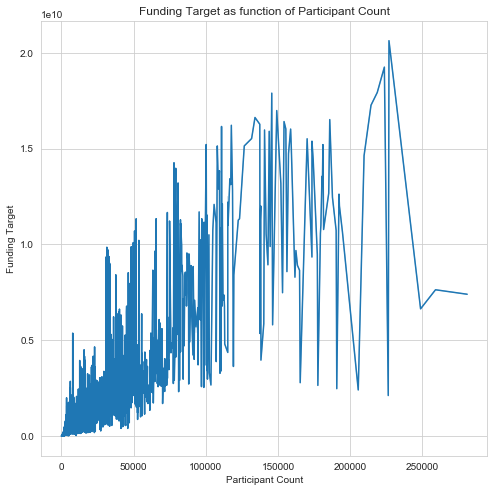

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax = sns.lineplot(x=df_payplan['sb_tot_partcp_cnt'], y=df_payplan['sb_tot_fndng_tgt_amt'])
plt.title('Funding Target as function of Participant Count')
plt.xlabel('Participant Count')
plt.ylabel('Funding Target')
plt.show()

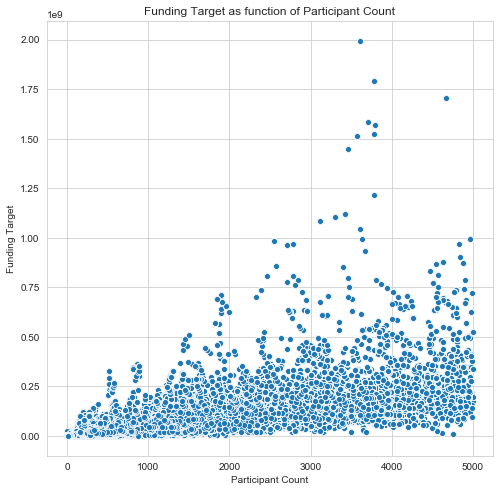

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax = sns.scatterplot(x=df_payplan[df_payplan['sb_tot_partcp_cnt']<5000]['sb_tot_partcp_cnt'], y=df_payplan[df_payplan['sb_tot_partcp_cnt']<5000]['sb_tot_fndng_tgt_amt'])
plt.title('Funding Target as function of Participant Count')
plt.xlabel('Participant Count')
plt.ylabel('Funding Target')
plt.show()

<h1>Funding Target vs Participant Count - Total and by Status</h1>

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_tot_partcp_cnt'], y=df['sb_tot_fndng_tgt_amt'])
plt.title('Participant Count vs Funding Target')
plt.xlabel('Participant Count')
plt.ylabel('Funding Target')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_act_partcp_cnt'], y=df['sb_liab_act_tot_fndng_tgt_amt'])
plt.title('Active: Participant Count vs Funding Target')
plt.xlabel('Active Participant Count')
plt.ylabel('Active Funding Target')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
x=df[df['sb_act_partcp_cnt']<20000]['sb_act_partcp_cnt']
y=df[df['sb_act_partcp_cnt']<20000]['sb_liab_act_tot_fndng_tgt_amt']
ax = sns.scatterplot(x=x, y=y)
plt.title('Active: Participant Count vs Funding Target (<20,000 Actives)')
plt.xlabel('Active Participant Count')
plt.ylabel('Active Funding Target')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_term_partcp_cnt'], y=df['sb_term_fndng_tgt_amt'])
plt.title('Vested Terminated: Participant Count vs Funding Target')
plt.xlabel('Terminated Participant Count')
plt.ylabel('Terminated Funding Target')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df['sb_rtd_partcp_cnt'], y=df['sb_rtd_fndng_tgt_amt'])
plt.title('Retired: Participant Count vs Funding Target')
plt.xlabel('Retired Participant Count')
plt.ylabel('Retired Funding Target')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(x=df[df['sb_rtd_partcp_cnt']<20000]['sb_rtd_partcp_cnt'], y=df[df['sb_rtd_partcp_cnt']<20000]['sb_rtd_fndng_tgt_amt'],)
plt.title('Retired: Participant Count vs Funding Target')
plt.xlabel('Retired Participant Count')
plt.ylabel('Retired Funding Target')
plt.show()